In [6]:
# Define all models from OpenMeteo
OPENMETEO_MODELS = {
    'KNMI': 'knmi_seamless',
    'MeteoFrance': 'meteofrance_seamless', 
    'MetnoSeamless': 'metno_seamless',
    'UkSeamless' : 'ukmo_seamless',
    'GEMSeamless' : 'gem_seamless'
    }

# Define all the locations
LOCATIONS = {
    'Maastricht': {'lat': 50.8514, 'lon': 5.6910, 'station_id': '06380'}
}

# Define the period for which the neural network will be trained
TRAIN_START = '2024-03-04'
TRAIN_END = '2024-08-26'

HISTORY_HOURS = 24 # How many hours of data the neural network gets before mkaing 1 prediction
PREDICTION_HOURS = 1 # How many hours into the future the neural network can predict
LSTM_UNITS = [64, 32] # How many LSTM neurons the neural network gets
DENSE_UNITS = 64 # How many dense layer neurons the neural network gets
EPOCHS = 20 # How many epochs the neural network trains
BATCH_SIZE = 32 # How big the batch size is on which the neural network trains
VALIDATION_SPLIT = 0.2 # How much of the training data is used for validation and training

FORECAST_HOUR_INDEX = 0 # Which future prediction hour of the neural network gets used for data analysis
SAMPLE_INDEX = 2 

# Define the parameters used for analysis
WEATHER_PARAMS = ['temp', 'prcp', 'dwpt', 'pres', 'rhum', 'wspd', 'wdir', 'coco']
MODEL_PARAMS = ['temp', 'prcp', 'dwpt', 'pres', 'rhum']
TARGET_PARAMS = ['temp', 'prcp']

# Define the measurement errors on the parameters
SIGMA_DICT = {
    'temp': 0.2,
    'prcp': 0.1,
}

# Define the lead time days
LEAD_TIMES = [0, 1, 2, 3, 4, 5, 6, 7]

In [7]:
from meteostat import Hourly
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
import numpy as np
from scipy import stats
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import combinations
from scipy.stats import normaltest, shapiro, jarque_bera, kstest, ttest_rel

In [8]:
# Class in which all the data is stored structurally for easy usage
class WeatherModel:
    
    def __init__(self):
        self.models = {}
    
    # When adding a new model to the class
    def add_model(self, model_name, location_name, **parameters):
        if model_name not in self.models:
            self.models[model_name] = {}        
        self.models[model_name][location_name] = parameters
    
    # Determines which model gets accessed
    def get_model(self, model_name):
        return self.models.get(model_name, {})
    
    # Determines whic locations gets accessed
    def get_location(self, model_name, location_name):
        model = self.models.get(model_name, {})
        return model.get(location_name, {})
    
    # Determines which parameter gets accessed
    def get_parameter(self, model_name, location_name, parameter_name):
        location = self.get_location(model_name, location_name)
        return location.get(parameter_name, None)
    
    # Gives all unique model names in this class
    def get_model_names(self):
        return list(self.models.keys())

In [9]:
# Function for getting the observational data from the online database
def get_observational_data(location_name, start_date, end_date, model_type):

    location_info = LOCATIONS[location_name] # Determine from which location the data gets selected
    station_id = location_info['station_id'] # Find the stations ID of the selected location
    start = datetime.strptime(start_date, '%Y-%m-%d') # Determine the start time
    end = datetime.strptime(end_date, '%Y-%m-%d') # Determine the end time
    data = Hourly(station_id, start, end).fetch() # Get the hourly data
    
    # Save all the useful parameters
    return {
        'time': data.index.tolist(),
        'temp': data['temp'].tolist(),
        'prcp': data['prcp'].tolist(),
        'dwpt': data['dwpt'].tolist(),
        'pres': data['pres'].tolist(),
        'rhum': data['rhum'].tolist(),
        'wdir': data.get('wdir', [np.nan] * len(data)).tolist(),
        'wspd': data.get('wspd', [np.nan] * len(data)).tolist(),
        'coco': data.get('coco', [np.nan] * len(data)).tolist()
    }



# Function for getting the model data
def get_openmeteo_data(location_name, start_date, end_date, model_type):

    location_info = LOCATIONS[location_name] # Determine from which location the data gets selected
    
    cache_session = requests_cache.CachedSession('.cache', expire_after=0)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)
    
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    
    # Determine the location, start and end date, the hourly parameters and which model to select
    params = {
        "latitude": location_info['lat'],
        "longitude": location_info['lon'],
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", 
                  "precipitation", "pressure_msl"],
        'models': model_type
    }
    
    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()
    
    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    
    # Save all the useful parameters
    return {
        'time': hourly_data['date'],
        'temp': hourly.Variables(0).ValuesAsNumpy(),
        'rhum': hourly.Variables(1).ValuesAsNumpy(),
        'dwpt': hourly.Variables(2).ValuesAsNumpy(),
        'prcp': hourly.Variables(3).ValuesAsNumpy(),
        'pres': hourly.Variables(4).ValuesAsNumpy()
    }



# Function for getting the lead time data
def get_openmeteo_leadtime_data(location_name, start_date, end_date, model_type, lead_days):

    location_info = LOCATIONS[location_name] # Determine from which location the data gets selected
    
    cache_session = requests_cache.CachedSession('.cache', expire_after=0)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)
    
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    
    hourly_params = []
    for day in lead_days:
        hourly_params.extend([
            f"temperature_2m_previous_day{day}",
            f"precipitation_previous_day{day}"
        ])
    
    # Determine the location, start and end date, the hourly parameters and which model to select
    params = {
        "latitude": location_info['lat'],
        "longitude": location_info['lon'],
        "start_date": start_date,
        "end_date": end_date,
        "hourly": hourly_params,
        'models': model_type
    }
    
    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()
    
    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    
    result = {'time': hourly_data['date']}
    var_index = 0
    
    # Create the lead time parameters
    for day in lead_days:
        result[f'temp_lead_{day}d'] = hourly.Variables(var_index).ValuesAsNumpy()
        var_index += 1
        result[f'prcp_lead_{day}d'] = hourly.Variables(var_index).ValuesAsNumpy()
        var_index += 1
    
    return result



# Function for collecting the lead time data and adding htem to the data class
def collect_leadtime_data(weather_data, model_configs, lead_days):

    for config in model_configs:
        if config['name'] == 'Observational':
            continue
            
        model_name = config['name'] + config.get('suffix', '')
        
        for location in config['locations']:
            try:
                leadtime_data = get_openmeteo_leadtime_data(
                    location, config['start_date'], config['end_date'], 
                    config['model_type'], lead_days
                )
                
                for lead_day in lead_days:
                    leadtime_model_name = f"{model_name}_lead_{lead_day}d"
                    leadtime_params = {
                        'time': leadtime_data['time'],
                        'temp': leadtime_data[f'temp_lead_{lead_day}d'],
                        'prcp': leadtime_data[f'prcp_lead_{lead_day}d']
                    }
                    weather_data.add_model(leadtime_model_name, location, **leadtime_params)
                    print(f"Collected {leadtime_model_name} data for {location}")
                    
            except Exception as e:
                print(f"Failed to collect lead time data for {model_name} at {location}: {str(e)}")


# Function for collecting the data from the databases and adding them to the data class
def collect_model_data(weather_data, model_configs):
      for config in model_configs:
        model_name = config['name'] + config.get('suffix', '')
        
        for location in config['locations']:
            try:
                model_data = config['function'](location, config['start_date'], config['end_date'], config['model_type'])
                weather_data.add_model(model_name, location, **model_data)
                print(f"Collected {model_name} data for {location}")
            except Exception as e:
                print(f"Failed to collect {model_name} data for {location}: {str(e)}")



# Function for aligning all the models and observational data to have the same time period
def align_models_by_time(weather_data, model_names, location, model_params, weather_params):
    
    # Get the observed times
    obs_times = np.array(weather_data.get_parameter("Observational", location, "time"))
    obs_times_pd = pd.to_datetime(obs_times).tz_localize(None)
    
    obs_param_arrays = []
    lengths = []

    # Get the parameters of the observational data and shortly store them in an array
    for param in weather_params:
        arr = np.array(weather_data.get_parameter("Observational", location, param))
        obs_param_arrays.append(arr)
        lengths.append(len(arr))

    # Determine which of the parameters contain nan values and only store the timestamps in which all parameters have values
    min_length = min(len(obs_times_pd), *lengths)
    obs_times_pd = obs_times_pd[:min_length]
    obs_param_arrays = [arr[:min_length] for arr in obs_param_arrays]
    obs_data = np.column_stack(obs_param_arrays)
    nan_mask = np.isnan(obs_data).any(axis=1)
    obs_times_clean = obs_times_pd[~nan_mask]
    obs_data_clean = obs_data[~nan_mask]

    # Clean the observational data such that only the cleaned timestamps remain and store them in the class
    for i, param in enumerate(weather_params):
        weather_data.models["Observational"][location][param] = obs_data_clean[:, i]
    weather_data.models["Observational"][location]["time"] = obs_times_clean.values

    # Get the parameters of all the models except for the observational data and store them shortly in an array
    for model_name in model_names:
        if model_name == "Observational": # Skip the observational data class
            continue

        # Get the timestamps of all the different models
        model_times = np.array(weather_data.get_parameter(model_name, location, "time"))
        
        # Check if the model contains any timestamps
        if model_times is None or len(model_times) == 0:
            print(f"{model_name} skipped — missing time entries.")
            continue

        model_times_pd = pd.to_datetime(model_times).tz_localize(None)
        shared_times = np.intersect1d(obs_times_clean, model_times_pd) # Check which times from the model overlaps with the observational data timestamps

        # Error if there are no shared timestamps
        if len(shared_times) == 0:
            print(f"{model_name} skipped — no overlapping time entries.")
            continue

        # Only store the shared timestamps for the observational and models data
        model_mask = np.isin(model_times_pd, shared_times)
        obs_mask = np.isin(obs_times_clean, shared_times)

        # Get the parameters of the models and shortly store them in an array
        for param in model_params:
            param_values = np.array(weather_data.get_parameter(model_name, location, param))
            
            # Check if the parameters and the timestamps are of equal length, if not shorten them to the shortest array
            if len(param_values) != len(model_times_pd):
                min_len = min(len(param_values), len(model_times_pd))
                param_values = param_values[:min_len]
                model_mask = model_mask[:min_len]

            # Store the cleaned parameters from the model back into the class
            weather_data.models[model_name][location][param] = param_values[model_mask]

        # Store the cleaned timestamps for the models back into the class
        weather_data.models[model_name][location]["time"] = model_times_pd[model_mask]
        
        pass

        # Print if the aligned was succesfull
        print(f"Aligned {model_name} with Observational — shared timestamps: {len(shared_times)}")




# Functions for cleaning and aligning the data of two models
def clean_and_align_data(weather_data, model_names, location, target_params, include_observations=True):

    cleaned_data = {}
    
    # Loop through the parameters that need cleaning
    for param in target_params:
        cleaned_data[param] = {}
        
        # Get the observational data and timestamps
        obs_data = weather_data.get_parameter('Observational', location, param)
        obs_times = weather_data.get_parameter('Observational', location, 'time')
    
        model_data_dict = {}
        model_times_dict = {}
        
        model_data_dict['Observational'] = obs_data
        model_times_dict['Observational'] = obs_times
        
        # Get the parameters and timestamps of each model that exists
        for model_name in model_names:
            model_data = weather_data.get_parameter(model_name, location, param)
            model_times = weather_data.get_parameter(model_name, location, 'time')
            
            # Only include models that have valid data
            if model_data is not None:
                model_data_dict[model_name] = model_data
                model_times_dict[model_name] = model_times
        
        # Find the shortest data length 
        min_len = min(len(data) for data in model_data_dict.values())

        # Align all the other models to the smallest data length
        aligned_data = {}
        aligned_times = {}
        for name, data in model_data_dict.items():
            aligned_data[name] = data[:min_len]
            if model_times_dict[name] is not None:
                aligned_times[name] = model_times_dict[name][:min_len]
        
        # Only store the timestamps in which ALL models contain no nan-values
        master_mask = np.ones(min_len, dtype=bool)
        for data in aligned_data.values():
            master_mask &= ~np.isnan(data)
    
        for name, data in aligned_data.items():
            data = np.array(data)
            time_array = aligned_times.get(name, None)
            if time_array is not None:
                time_array = np.array(time_array)
                # Make sure time_array is same length as data
                if len(time_array) != len(data):
                    # Trim time_array to data length (or vice versa) to align lengths
                    min_length = min(len(time_array), len(data))
                    data = data[:min_length]
                    time_array = time_array[:min_length]
                
                # Now apply master_mask
                time_array = time_array[master_mask[:len(time_array)]]
                data = data[master_mask[:len(data)]]
            else:
                data = data[master_mask[:len(data)]]

            cleaned_data[param][name] = {
                'data': data,
                'time': time_array,
                'clean_indices': np.where(master_mask)[0]
            }
    
    # Store the cleaned and aligned data back into the weather_data class
    for param in target_params:
        for model_name in cleaned_data[param]:
            # Store cleaned parameter data
            weather_data.models[model_name][location][param] = cleaned_data[param][model_name]['data']
            
            # Store cleaned timestamps
            if cleaned_data[param][model_name]['time'] is not None:
                weather_data.models[model_name][location]['time'] = cleaned_data[param][model_name]['time']
    
    return cleaned_data



# Function for calculating the chi squared of a model with respect to the observational data
def calculate_chi_squared(obs_clean, model_clean, sigma):

    residual = model_clean - obs_clean
    chi2 = np.sum((residual / sigma) ** 2)
    dof = len(obs_clean) - 1 if len(obs_clean) > 1 else 1
    chi2_red = chi2 / dof

    return chi2, chi2_red



# Function for analysing the chi sqaured values for the lead times
def analyze_leadtime_chi_squared(weather_data, location, target_params, lead_days):
    results = {}

    for param in target_params:
        results[param] = {}
        sigma = SIGMA_DICT[param]

        obs_data = weather_data.get_parameter('Observational', location, param)
        obs_times = weather_data.get_parameter('Observational', location, 'time')

        if obs_data is None:
            continue

        for model_base in OPENMETEO_MODELS.keys():
            results[param][model_base] = {'lead_days': [], 'chi2': []}

            for lead_day in lead_days:
                leadtime_model_name = f"{model_base}_lead_{lead_day}d"
                model_data = weather_data.get_parameter(leadtime_model_name, location, param)

                if model_data is None or len(model_data) == 0:
                    continue

                min_len = min(len(obs_data), len(model_data))
                obs_aligned = obs_data[:min_len]
                model_aligned = model_data[:min_len]

                valid_mask = ~(np.isnan(obs_aligned) | np.isnan(model_aligned))
                obs_clean = obs_aligned[valid_mask]
                model_clean = model_aligned[valid_mask]

                if len(obs_clean) > 0:
                    print(f"[{param}] {model_base} (lead {lead_day}d): obs_len={len(obs_clean)}, model_len={len(model_clean)}, mean_diff={np.mean(np.abs(model_clean - obs_clean)):.3f}")
                    chi2, chi2_red = calculate_chi_squared(obs_clean, model_clean, sigma)
                    results[param][model_base]['lead_days'].append(lead_day)
                    results[param][model_base]['chi2'].append(chi2_red) 

        for model_base in OPENMETEO_MODELS.keys():
             if model_base in results[param]:
                 chi2_vals = results[param][model_base]['chi2']
                 if not chi2_vals:
                    continue
                 model_min_chi2 = min(chi2_vals)
                 normalized = [(chi2 / model_min_chi2) if model_min_chi2 else np.nan for chi2 in chi2_vals]
                 results[param][model_base]['chi2_normalized'] = normalized

        
    return results



# Function for plotting the chi sqaured values per lead time
def plot_leadtime_chi_squared(results, target_params):
    
    fig, axes = plt.subplots(1, len(target_params), figsize=(6*len(target_params), 6))
    if len(target_params) == 1:
        axes = [axes]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(OPENMETEO_MODELS)))
    
    for i, param in enumerate(target_params):
        ax = axes[i]
        
        for j, (model_name, color) in enumerate(zip(OPENMETEO_MODELS.keys(), colors)):
            if model_name in results[param] and 'chi2_normalized' in results[param][model_name]:
                lead_days = results[param][model_name]['lead_days']
                chi2_values = results[param][model_name]['chi2_normalized']
                
                if len(lead_days) > 0:
                    sorted_pairs = sorted(zip(lead_days, chi2_values), reverse=True)
                    sorted_lead_days, sorted_chi2_values = zip(*sorted_pairs)
                    
                    ax.plot(sorted_lead_days, sorted_chi2_values, 'o-', color=color, 
                           label=model_name, linewidth=2, markersize=6)
        
        ax.set_xlabel('Lead Time (days)', fontsize=12)
        ax.set_ylabel('Normalized Chi-squared ', fontsize=12)
        ax.set_title(f'Normalized Chi-squared vs Lead Time - {param.upper()}', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        ax.set_xlim(7.5, -0.5)
        ax.set_xticks(range(7, -1, -1))
        
        if len([v for model_data in results[param].values() 
               if 'chi2_normalized' in model_data 
               for v in model_data['chi2_normalized']]) > 0:
            all_chi2 = [v for model_data in results[param].values() 
                       if 'chi2_normalized' in model_data 
                       for v in model_data['chi2_normalized']]
            ax.set_ylim(0, max(all_chi2) * 1.05)
    
    plt.tight_layout()
    plt.show()

In [10]:
# Create the class for all the models to be stored in
weather_data = WeatherModel()
    
# Configurations with the right parameters for the observational data to use to store the data in the class    
training_configs = [
    {
        'name': 'Observational',
        'function': get_observational_data,
        'locations': list(LOCATIONS.keys()),
        'start_date': TRAIN_START,
        'end_date': TRAIN_END,
        'suffix': '',
        'model_type': 'none'
    }
]

# Configurations with the right parameters for the data of the different models to use to store the data in the class
for model_name, model_type in OPENMETEO_MODELS.items():
    training_configs.append({
        'name': model_name,
        'function': get_openmeteo_data,
        'locations': ['Maastricht'], 
        'start_date': TRAIN_START,
        'end_date': TRAIN_END,
        'suffix': '',
        'model_type': model_type
    })

collect_model_data(weather_data, training_configs)

collect_leadtime_data(weather_data, training_configs, LEAD_TIMES)

Collected Observational data for Maastricht
Collected KNMI data for Maastricht
Collected MeteoFrance data for Maastricht
Collected MetnoSeamless data for Maastricht
Collected UkSeamless data for Maastricht
Collected GEMSeamless data for Maastricht
Collected KNMI_lead_0d data for Maastricht
Collected KNMI_lead_1d data for Maastricht
Collected KNMI_lead_2d data for Maastricht
Collected KNMI_lead_3d data for Maastricht
Collected KNMI_lead_4d data for Maastricht
Collected KNMI_lead_5d data for Maastricht
Collected KNMI_lead_6d data for Maastricht
Collected KNMI_lead_7d data for Maastricht
Collected MeteoFrance_lead_0d data for Maastricht
Collected MeteoFrance_lead_1d data for Maastricht
Collected MeteoFrance_lead_2d data for Maastricht
Collected MeteoFrance_lead_3d data for Maastricht
Collected MeteoFrance_lead_4d data for Maastricht
Collected MeteoFrance_lead_5d data for Maastricht
Collected MeteoFrance_lead_6d data for Maastricht
Collected MeteoFrance_lead_7d data for Maastricht
Collecte

In [11]:
model_names = weather_data.get_model_names()
align_models_by_time(weather_data, [name for name in model_names if not '_lead_' in name], 
                    'Maastricht', MODEL_PARAMS, WEATHER_PARAMS)

leadtime_models = [name for name in model_names if '_lead_' in name]
align_models_by_time(weather_data, leadtime_models, 'Maastricht', TARGET_PARAMS, WEATHER_PARAMS)

Aligned KNMI with Observational — shared timestamps: 4201
Aligned MeteoFrance with Observational — shared timestamps: 4201
Aligned MetnoSeamless with Observational — shared timestamps: 4201
Aligned UkSeamless with Observational — shared timestamps: 4201
Aligned GEMSeamless with Observational — shared timestamps: 4201
Aligned KNMI_lead_0d with Observational — shared timestamps: 4201
Aligned KNMI_lead_1d with Observational — shared timestamps: 4201
Aligned KNMI_lead_2d with Observational — shared timestamps: 4201
Aligned KNMI_lead_3d with Observational — shared timestamps: 4201
Aligned KNMI_lead_4d with Observational — shared timestamps: 4201
Aligned KNMI_lead_5d with Observational — shared timestamps: 4201
Aligned KNMI_lead_6d with Observational — shared timestamps: 4201
Aligned KNMI_lead_7d with Observational — shared timestamps: 4201
Aligned MeteoFrance_lead_0d with Observational — shared timestamps: 4201
Aligned MeteoFrance_lead_1d with Observational — shared timestamps: 4201
Aligned

In [12]:
leadtime_results = analyze_leadtime_chi_squared(weather_data, 'Maastricht', TARGET_PARAMS, LEAD_TIMES)

[temp] KNMI (lead 0d): obs_len=4201, model_len=4201, mean_diff=1.071
[temp] KNMI (lead 1d): obs_len=4201, model_len=4201, mean_diff=1.188
[temp] KNMI (lead 2d): obs_len=4201, model_len=4201, mean_diff=1.002
[temp] KNMI (lead 3d): obs_len=4201, model_len=4201, mean_diff=1.107
[temp] KNMI (lead 4d): obs_len=4201, model_len=4201, mean_diff=1.366
[temp] KNMI (lead 5d): obs_len=4201, model_len=4201, mean_diff=1.572
[temp] KNMI (lead 6d): obs_len=4201, model_len=4201, mean_diff=1.910
[temp] KNMI (lead 7d): obs_len=4201, model_len=4201, mean_diff=2.129
[temp] MeteoFrance (lead 0d): obs_len=4201, model_len=4201, mean_diff=1.597
[temp] MeteoFrance (lead 1d): obs_len=4201, model_len=4201, mean_diff=1.617
[temp] MeteoFrance (lead 2d): obs_len=4201, model_len=4201, mean_diff=1.152
[temp] MeteoFrance (lead 3d): obs_len=4201, model_len=4201, mean_diff=1.338
[temp] MetnoSeamless (lead 0d): obs_len=4201, model_len=4201, mean_diff=0.711
[temp] MetnoSeamless (lead 1d): obs_len=4201, model_len=4201, mean

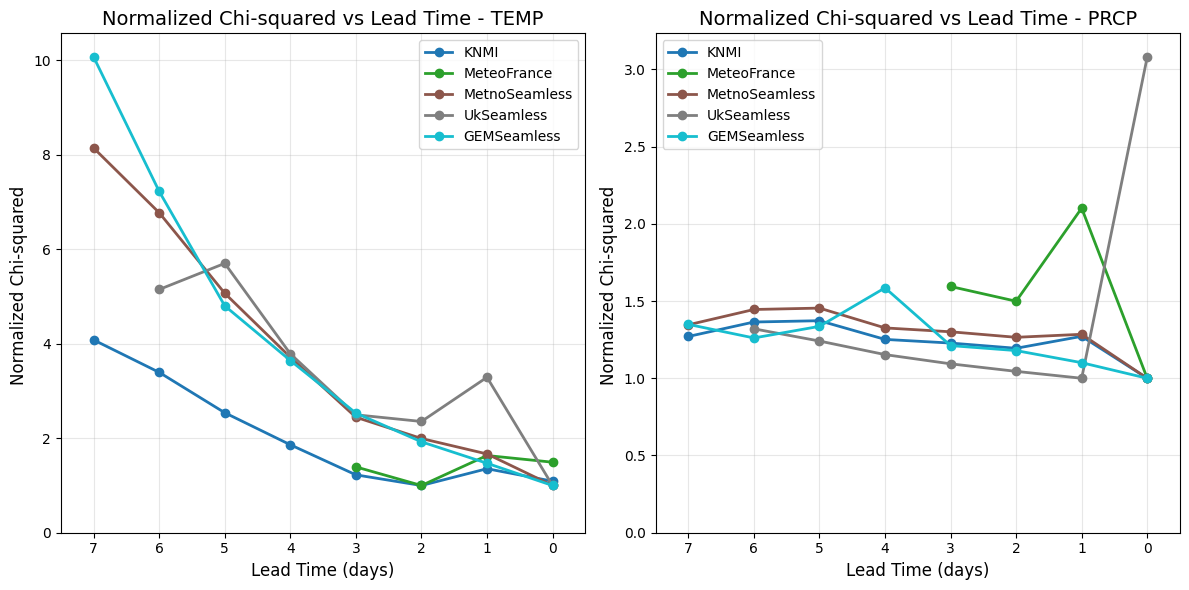

In [13]:
plot_leadtime_chi_squared(leadtime_results, TARGET_PARAMS)